___Practica No. 4___<br>
___Autor:___ Alejandro Hernández<br>
___Fecha:___ 2023-05-02<br>
============================================<br>
___Revisión histórica:___
* Versión 1.0 | 2023-05-02 | Practica No. 4, Riesgo de crédito

============================================<br>


### Contenido <a class="anchor" id="top"></a>
 
* [1. Carga librerías](#librerias)
* [2. Carga de datos](#datos)
* [3. Exploración de datos](#exploracion)

### 1. Carga de librerías <a class="anchor" id="librerias"></a>

In [41]:
import pandas as pd
import numpy as np
seed = 10
np.random.seed(seed)
 
import datetime as dt
from datetime import datetime as dt
 
#from dataprep.eda.missing import plot_missing
#from dataprep.eda import plot, plot_correlation
 
# Visualización
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams 
 
# 
from sklearn.manifold import TSNE # Análisis de separabilidad de las variables
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import warnings
warnings.filterwarnings("ignore")
 
#
import sklearn 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
 
# Preprocesado de datos: Pipeline y ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

### 2. Carga de datos <a class="anchor" id="datos"></a>

In [42]:
df = pd.read_csv("data/credit_risk_dataset.csv")

In [43]:
df.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [44]:
# Index 0. loan_amnt/person_income = loan_percent_income. Se pueden quitar las primeras 2.
35000/59000

0.5932203389830508

Variable objetivo salida: loan_status

In [45]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


#### Remover duplicados

In [46]:
print(f'Total registros de créditos: {len(df)}.  Valores unicos: {df.drop_duplicates().shape[0]}')

Total registros de créditos: 32581.  Valores unicos: 32416


In [47]:
# Eliminar los duplicados
df = df.drop_duplicates()

### 3 Exploración de datos <a class="anchor" id="exploracion"></a>

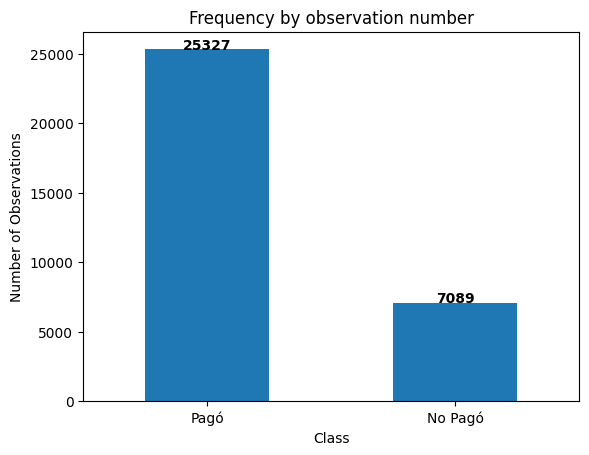

In [48]:
# TODO Entender el balance de las clases visual o númerica. 1 pagó, 0 no pagó
count_classes = pd.value_counts(df['loan_status'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
LABELS= ['Pagó','No Pagó']
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");
for i, v in enumerate(count_classes):
    plt.text(i, v+1, str(v), ha='center', fontweight='bold')

In [49]:
# Porcentaje de los que pagan
25327/(25327+7089)*100

78.13116979269496

In [50]:
# Porcentaje de los no que pagan
7089/(25327+7089)*100

21.868830207305034

#### Análisis de correlación

In [51]:
# Eliminar var person_income y loan_percent_income por dependencia con loan_amount.
# loan_amnt -> Se deja suponiendo que no crece drasticamente en el tiempo y al quitar la otra ya no hay correlación
# Variables de dinero no se recomiendan en los modelos por la inflación
# Para poder calcular la correlacionada se necesitaban las otras 2
df = df.drop(["person_income"], axis=1)

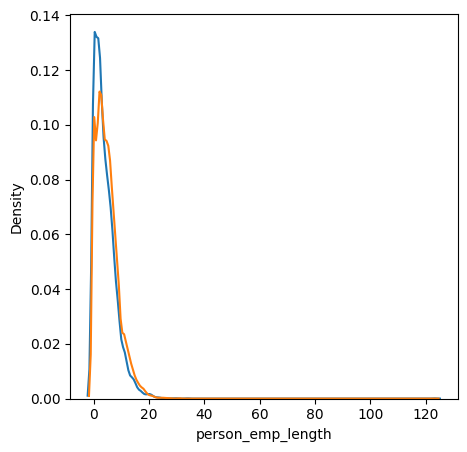

In [52]:
buenos = df[df['loan_status'] == 1]
malos  = df[df['loan_status'] == 0]
# Distribución plot person_empt_length
variable_to_plot = 'person_emp_length'
plt.figure(figsize=(5,5))
ax = sns.distplot(buenos[variable_to_plot], label='buenos', hist=False)
ax = sns.distplot(malos[variable_to_plot], label='malos', hist=False)
ax.set(xlabel = variable_to_plot)
plt.show()

### Análisis de la Varianza 

In [53]:
df_var = pd.DataFrame(
    {'Variable':np.array(df.var().index),
     'Variance': df.var().values
     }
)
df_var[df_var['Variance']<=0.1]

,Variable,Variance
5,loan_percent_income,0.011409


In [54]:
# entre 50 y 75% porciento mayoría de los datos. Se decide dejarla y se verá después
df['loan_percent_income'].describe()

count    32416.000000
mean         0.170250
std          0.106812
min          0.000000
25%          0.090000
50%          0.150000
75%          0.230000
max          0.830000
Name: loan_percent_income, dtype: float64

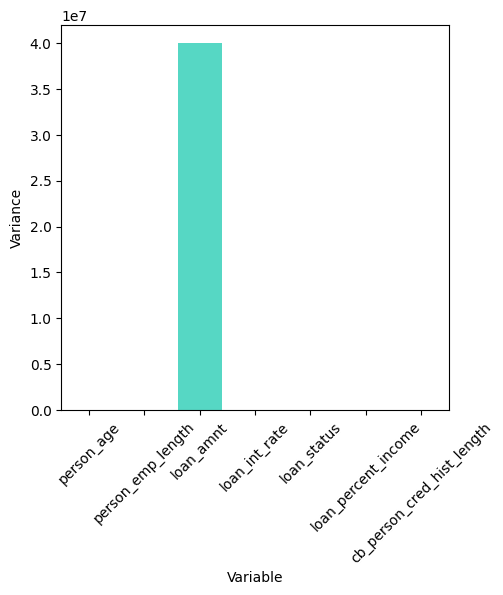

In [55]:
# Diagrama de barrras visualizar comportamiento variable en 
variable_to_plot = 'person_emp_length'
plt.figure(figsize=(5,5))
sns.barplot(df_var, x='Variable', y='Variance', palette='rainbow')
plt.xticks(rotation=45)
plt.show()


In [57]:
def convert_cat_to_dummy(data, var_name, drop_values_list):
    # Getting  dummies
    variable_dummy = pd.get_dummies(data[var_name],prefix=var_name).astype('int')

    # Eliminar variables con multicolinealidad o irrelevantes
    variable_dummy = variable_dummy.drop(drop_values_list, axis=1)

    # Concatenar con df
    df_new = pd.concat([data, variable_dummy], axis=1)

    # Borrar variable original
    df_new = df_new.drop([var_name], axis=1)
    return df_new

In [56]:
# Convertir variables categóricas a dummy
categorical_var = 'person_home_ownership'
df.groupby(categorical_var)[categorical_var].count()

person_home_ownership
MORTGAGE    13369
OTHER         106
OWN          2563
RENT        16378
Name: person_home_ownership, dtype: int64

In [58]:
categorical_var = 'person_home_ownership'
multi_variables = ['person_home_ownership_OTHER']
df = convert_cat_to_dummy(df, categorical_var, multi_variables)
df.head()


,person_age,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT
0,22,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0,0,1
1,21,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0,1,0
2,25,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,1,0,0
3,23,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0,0,1
4,24,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0,0,1


In [61]:
# Convertir variables categóricas a dummy
categorical_var = 'loan_intent'
df.groupby(categorical_var)[categorical_var].count()
# Se elimina una porque con todas 0 se calculan other

loan_intent
DEBTCONSOLIDATION    5189
EDUCATION            6411
HOMEIMPROVEMENT      3594
MEDICAL              6042
PERSONAL             5498
VENTURE              5682
Name: loan_intent, dtype: int64

In [63]:
categorical_var = 'loan_intent'
multi_variables = ['loan_intent_HOMEIMPROVEMENT']
df = convert_cat_to_dummy(df, categorical_var, multi_variables)
df.head()

,person_age,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22,123.0,D,35000,16.02,1,0.59,Y,3,0,0,1,0,0,0,1,0
1,21,5.0,B,1000,11.14,0,0.10,N,2,0,1,0,0,1,0,0,0
2,25,1.0,C,5500,12.87,1,0.57,N,3,1,0,0,0,0,1,0,0
3,23,4.0,C,35000,15.23,1,0.53,N,2,0,0,1,0,0,1,0,0
4,24,8.0,C,35000,14.27,1,0.55,Y,4,0,0,1,0,0,1,0,0


In [64]:
# Convertir variables categóricas a dummy
categorical_var = 'loan_grade'
df.groupby(categorical_var)[categorical_var].count()
# Se elimina una porque con todas 0 se calculan other

loan_grade
A    10703
B    10387
C     6438
D     3620
E      963
F      241
G       64
Name: loan_grade, dtype: int64

In [65]:
categorical_var = 'loan_grade'
multi_variables = ['loan_grade_E', 'loan_grade_F', 'loan_grade_G']
df = convert_cat_to_dummy(df, categorical_var, multi_variables)
df.head()

,person_age,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D
0,22,123.0,35000,16.02,1,0.59,Y,3,0,0,1,0,0,0,1,0,0,0,0,1
1,21,5.0,1000,11.14,0,0.10,N,2,0,1,0,0,1,0,0,0,0,1,0,0
2,25,1.0,5500,12.87,1,0.57,N,3,1,0,0,0,0,1,0,0,0,0,1,0
3,23,4.0,35000,15.23,1,0.53,N,2,0,0,1,0,0,1,0,0,0,0,1,0
4,24,8.0,35000,14.27,1,0.55,Y,4,0,0,1,0,0,1,0,0,0,0,1,0


In [66]:
# Convertir variables categóricas a dummy
categorical_var = 'loan_status'
df.groupby(categorical_var)[categorical_var].count()
# Se elimina una porque con todas 0 se calculan other

loan_status
0    25327
1     7089
Name: loan_status, dtype: int64

In [68]:
categorical_var = 'loan_status'
multi_variables = ['loan_status_1']
df = convert_cat_to_dummy(df, categorical_var, multi_variables)
df.head()

,person_age,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_status_0
0,22,123.0,35000,16.02,0.59,Y,3,0,0,1,0,0,0,1,0,0,0,0,1,0
1,21,5.0,1000,11.14,0.10,N,2,0,1,0,0,1,0,0,0,0,1,0,0,1
2,25,1.0,5500,12.87,0.57,N,3,1,0,0,0,0,1,0,0,0,0,1,0,0
3,23,4.0,35000,15.23,0.53,N,2,0,0,1,0,0,1,0,0,0,0,1,0,0
4,24,8.0,35000,14.27,0.55,Y,4,0,0,1,0,0,1,0,0,0,0,1,0,0


In [69]:
# Convertir variables categóricas a dummy
categorical_var = 'cb_person_default_on_file'
df.groupby(categorical_var)[categorical_var].count()
# Se elimina una porque con todas 0 se calculan other

cb_person_default_on_file
N    26686
Y     5730
Name: cb_person_default_on_file, dtype: int64

In [70]:
categorical_var = 'cb_person_default_on_file'
multi_variables = ['cb_person_default_on_file_Y']
df = convert_cat_to_dummy(df, categorical_var, multi_variables)
df.head()

,person_age,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_status_0,cb_person_default_on_file_N
0,22,123.0,35000,16.02,0.59,3,0,0,1,0,0,0,1,0,0,0,0,1,0,0
1,21,5.0,1000,11.14,0.10,2,0,1,0,0,1,0,0,0,0,1,0,0,1,1
2,25,1.0,5500,12.87,0.57,3,1,0,0,0,0,1,0,0,0,0,1,0,0,1
3,23,4.0,35000,15.23,0.53,2,0,0,1,0,0,1,0,0,0,0,1,0,0,1
4,24,8.0,35000,14.27,0.55,4,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [71]:
# Convertir variables categóricas a dummy
categorical_var = 'cb_person_cred_hist_length'
df.groupby(categorical_var)[categorical_var].count()
# Se elimina una porque con todas 0 se calculan other

cb_person_cred_hist_length
2     5925
3     5905
4     5881
5     1875
6     1849
7     1898
8     1893
9     1888
10    1846
11     462
12     483
13     443
14     492
15     437
16     449
17     406
18      19
19      21
20      31
21      20
22      22
23      22
24      30
25      18
26      16
27      22
28      27
29      14
30      22
Name: cb_person_cred_hist_length, dtype: int64

In [ ]:
# Predi
X 

In [ ]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD Implementation
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

In [ ]:
f, ax = plt.subplots(1,3,figsize = (16,5))

# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

# t-SNE scatter plot
sns.scatterplot(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], hue = y, ax=ax[0])
ax[0].set_title('t-SNE', fontsize=14)
ax[0].grid(True)

# PCA scatter plot
sns.scatterplot(X_reduced_pca[:, 0], X_reduced_pca[:, 1], hue = y, ax=ax[1])
ax[1].set_title('PCA', fontsize=14)
ax[1].grid(True)

# TruncatedSVD scatter plot
sns.scatterplot(X_reduced_svd[:, 0], X_reduced_svd[:, 1], hue = y, ax=ax[2])
ax[2].set_title('Truncated SVD', fontsize=14)
ax[2].grid(True)

plt.show()